<a href="https://colab.research.google.com/github/aaravrao12/Smart-Waste-Management/blob/main/CNN_model(1)_h5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7238 - loss: 0.9216Epoch 1/10 - 123s - accuracy: 0.7927 - loss: 0.8526 - val_accuracy: 0.8464 - val_loss: 0.7580
49/49 ━━━━━━━━━━━━━━━━━━━━ 123s 750ms/step - accuracy: 0.7252 - loss: 0.9202 - val_accuracy: 0.8464 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9010 - loss: 0.6060Epoch 2/10 - 22s - accuracy: 0.9031 - loss: 0.5416 - val_accuracy: 0.8964 - val_loss: 0.4337
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 442ms/step - accuracy: 0.9011 - loss: 0.6047 - val_accuracy: 0.8964 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9286 - loss: 0.3791Epoch 3/10 - 45s - accuracy: 0.9305 - loss: 0.3462 - val_accuracy: 0.9464 - val_loss: 0.2830
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 529ms/step - accuracy: 0.9287 - loss: 0.3784 - val_accuracy: 0.9464 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 860ms/step - accuracy: 0.9638 - loss: 0.0611
Test Accuracy: 0.9609
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 828ms/step


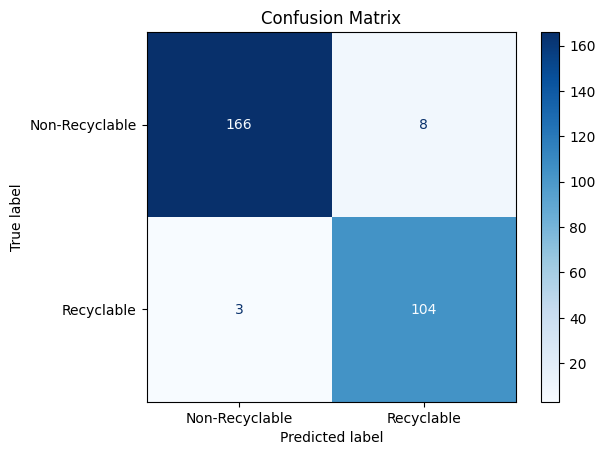

                precision    recall  f1-score   support

Non-Recyclable       0.98      0.95      0.97       174
    Recyclable       0.93      0.97      0.95       107

      accuracy                           0.96       281
     macro avg       0.96      0.96      0.96       281
  weighted avg       0.96      0.96      0.96       281



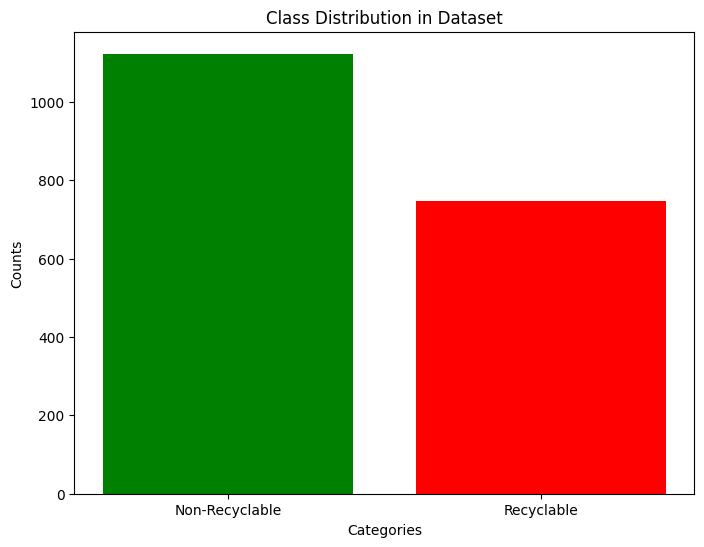

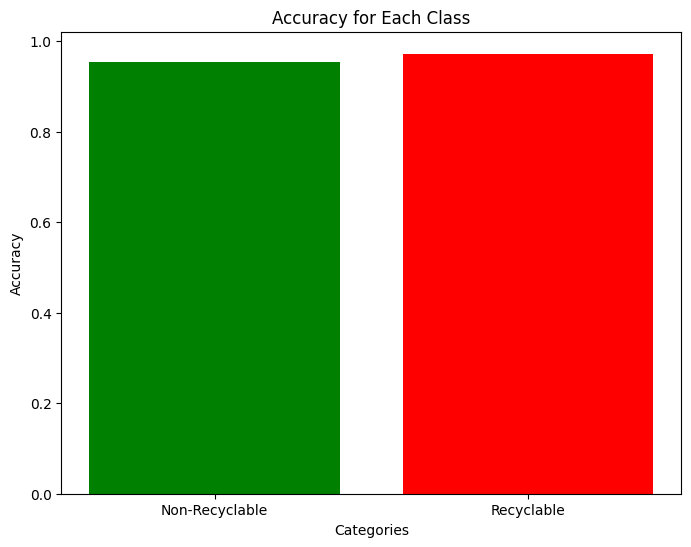

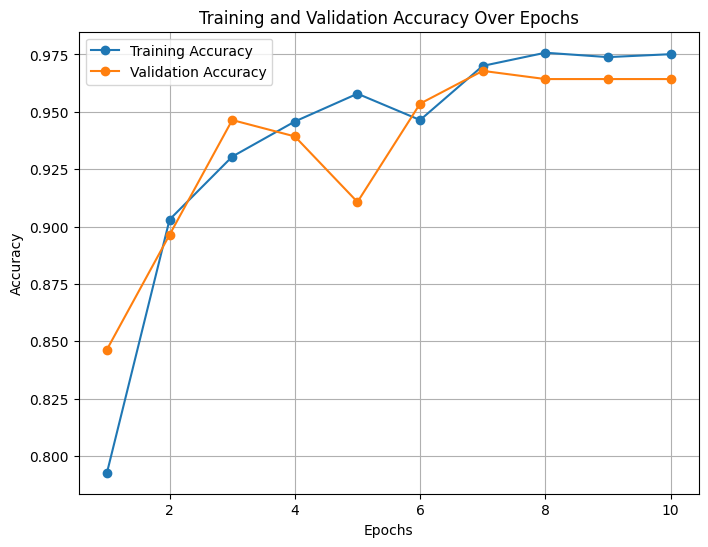

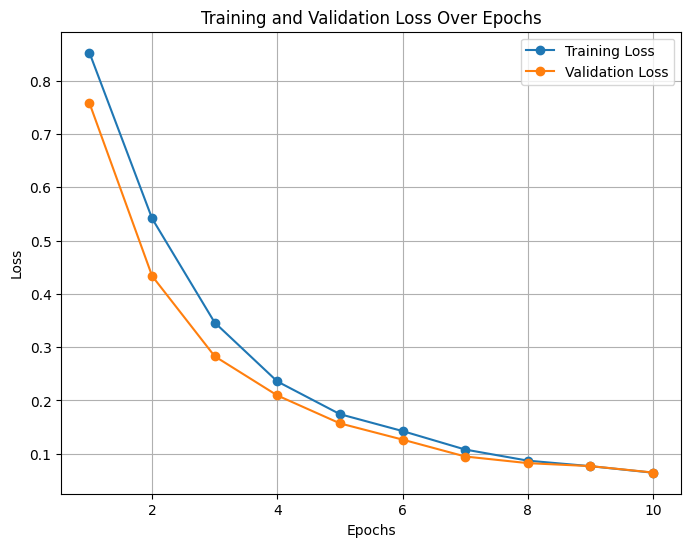

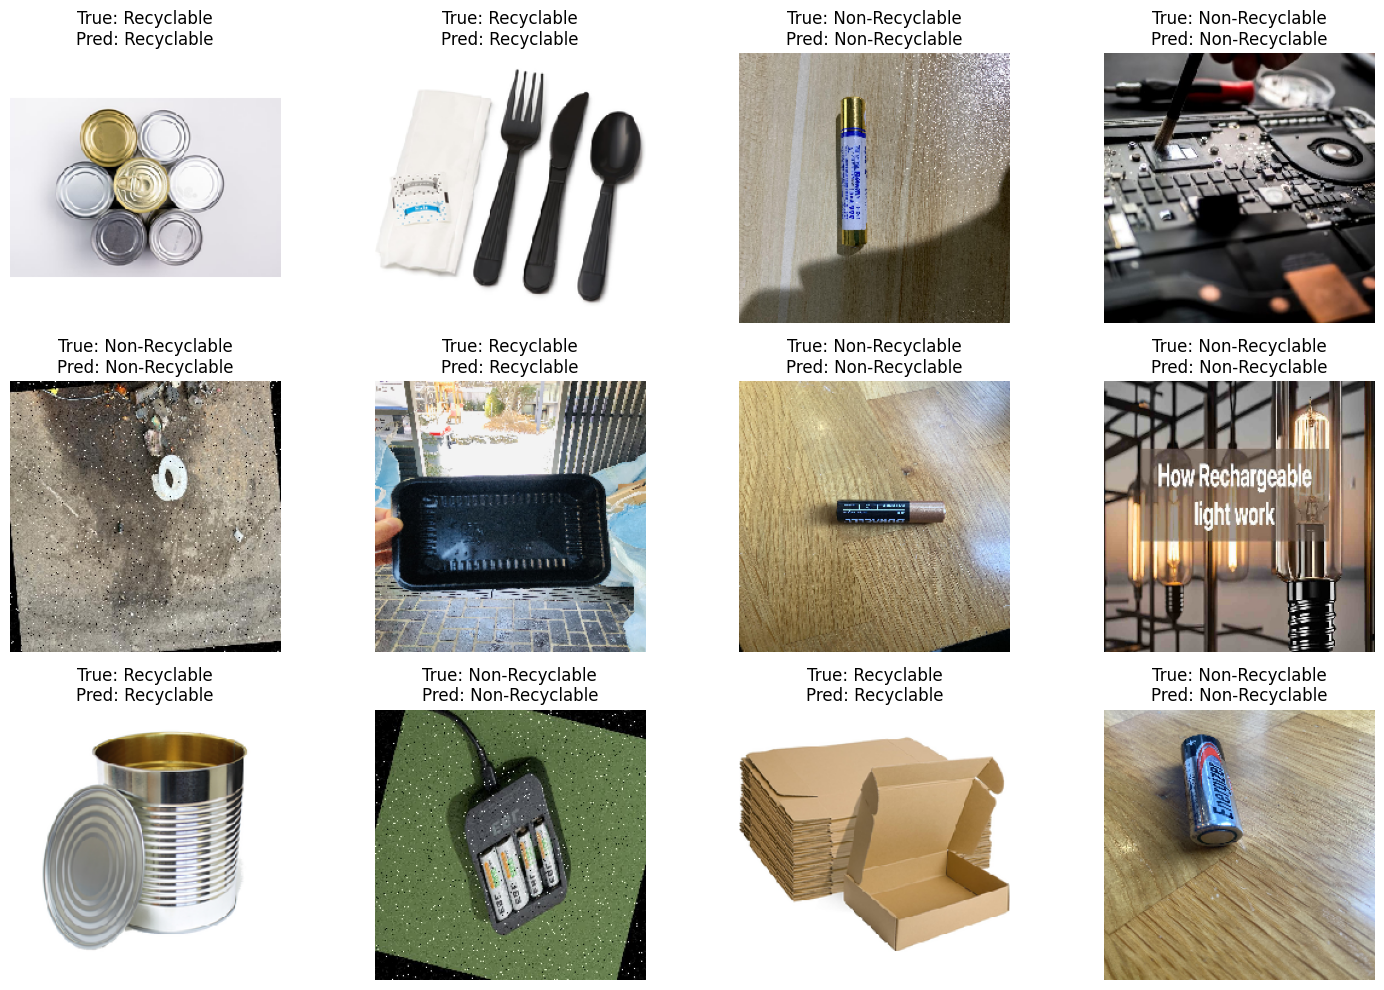

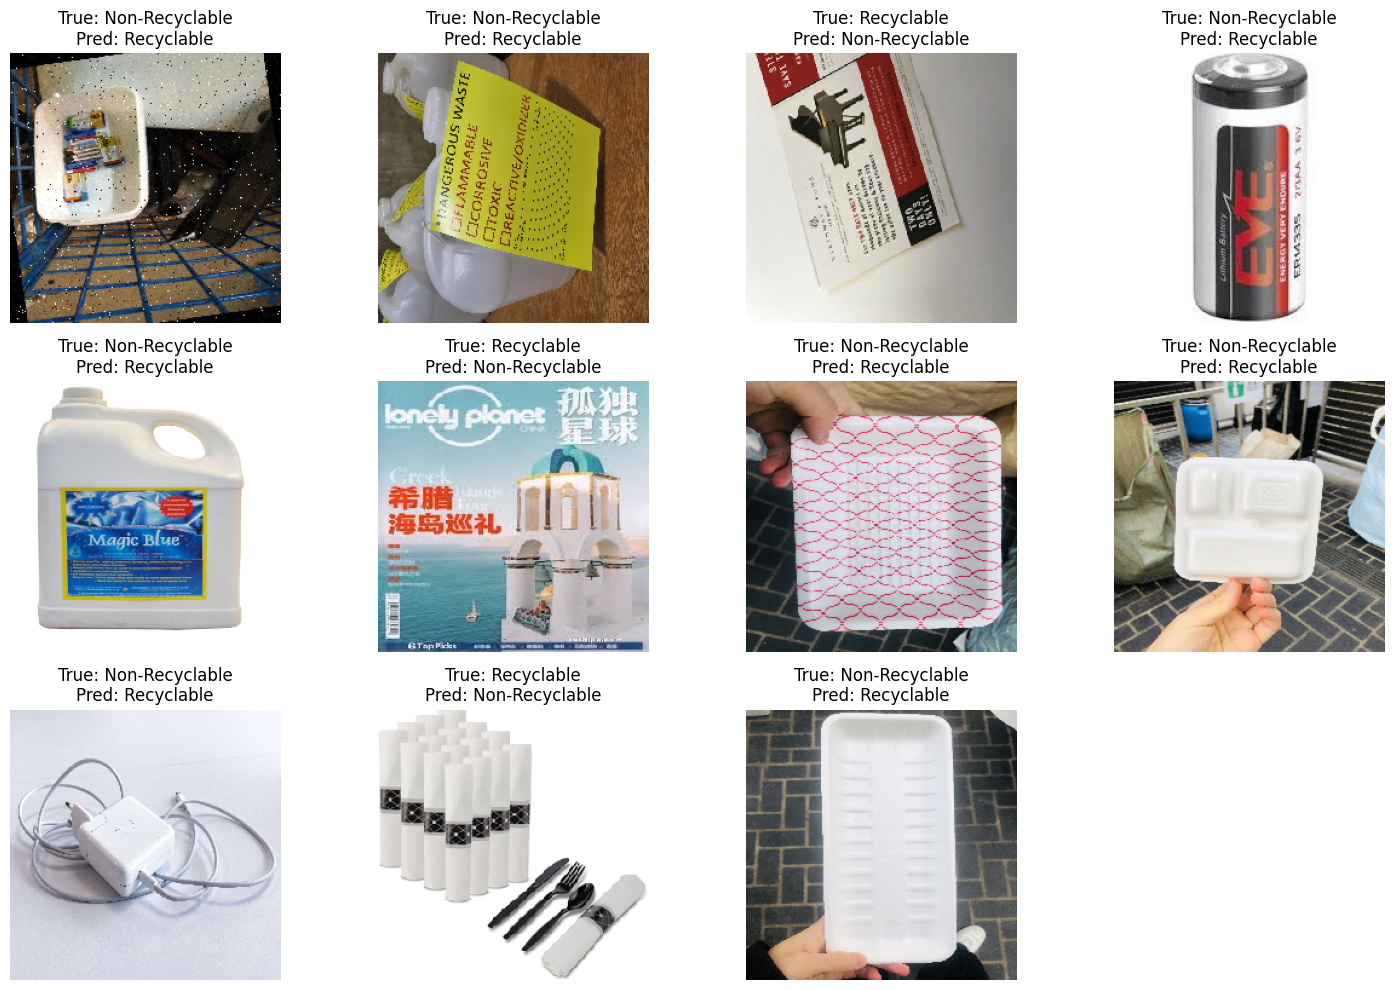

ValueError: No such layer: top_conv. Existing layers are: ['efficientnetb0', 'flatten', 'dense', 'batch_normalization', 'dropout', 'dense_1'].

In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler
from imblearn.over_sampling import RandomOverSampler
import time
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import to_categorical

# Enable mixed precision for faster training
policy = mixed_precision.Policy('mixed_bfloat16')
mixed_precision.set_global_policy(policy)

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Define paths to the folders with images (Recyclable and Non-Recyclable)
folder_paths = {
    'Recyclable': r"/content/drive/MyDrive/Recyclable/Recyclables",
    'Non-Recyclable': r"/content/drive/MyDrive/Non_Recyclable/NonRecyclable"
}

# Load images and labels
images, labels = [], []
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']

for label, folder_path in folder_paths.items():
    if os.path.exists(folder_path):
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            img_path = os.path.join(folder_path, image_file)
            if os.path.isfile(img_path) and any(img_path.lower().endswith(ext) for ext in valid_extensions):
                try:
                    img = image.load_img(img_path, target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Preprocess input data
X = preprocess_input(X)

# Encode labels (Recyclable and Non-Recyclable)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Compute class weights (for imbalanced classes)
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Oversampling using RandomOverSampler (optional to balance classes)
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)

# Convert labels to one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=len(np.unique(y_encoded)))
y_val = to_categorical(y_val, num_classes=len(np.unique(y_encoded)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y_encoded)))

# Data augmentation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator()

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    return lr * 0.7 if epoch > 0 and epoch % 5 == 0 else lr

# Custom Logging Callback
class CustomLoggingCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.epoch_start_time
        logs = logs or {}
        print(f"Epoch {epoch+1}/{self.params['epochs']} - {duration:.0f}s - "
              f"accuracy: {logs.get('accuracy'):.4f} - loss: {logs.get('loss'):.4f} - "
              f"val_accuracy: {logs.get('val_accuracy'):.4f} - val_loss: {logs.get('val_loss'):.4f}")

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# Define model architecture using EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(np.unique(y_encoded)), activation='softmax', dtype='float32')  # Output layer matches the number of classes
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=focal_loss(),
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train model
history = model.fit(
    datagen_train.flow(X_train_resampled, y_train_resampled, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stopping, model_checkpoint, lr_schedule, CustomLoggingCallback()],
    class_weight=class_weights_dict
)

# Save model
model.save('/content/drive/MyDrive/app_model.h5')

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions and create confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)

if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=le.classes_)
print(class_report)

# Visualizations
# 1. Bar Graph of Class Distribution
labels = le.classes_
class_counts = [np.sum(y_encoded == i) for i in range(len(labels))]
plt.figure(figsize=(8, 6))
plt.bar(labels, class_counts, color=['green', 'red', 'orange'])
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Class Distribution in Dataset')
plt.show()

# 2. Bar Graph of Accuracy for Each Class
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracy_per_class, color=['green', 'red', 'orange'])
plt.xlabel('Categories')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.show()

# 3. Line Graph for Training and Validation Accuracy
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

# 4. Line Graph for Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# 5. Sample Predictions
def plot_sample_predictions(X, y, y_pred, le):
    plt.figure(figsize=(15, 10))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X[i].astype("uint8"))
        plt.title(f'True: {le.inverse_transform([y[i]])[0]}\nPred: {le.inverse_transform([y_pred[i]])[0]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_predictions(X_test, y_test, y_pred, le)

# 6. Misclassified Examples
misclassified_indices = np.where(y_pred != y_test)[0]
def plot_misclassified(X, y, y_pred, le):
    plt.figure(figsize=(15, 10))
    for i in range(min(12, len(misclassified_indices))):
        idx = misclassified_indices[i]
        plt.subplot(3, 4, i + 1)
        plt.imshow(X[idx].astype("uint8"))
        plt.title(f'True: {le.inverse_transform([y[idx]])[0]}\nPred: {le.inverse_transform([y_pred[idx]])[0]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_misclassified(X_test, y_test, y_pred, le)

# 7. Class Activation Maps (CAM)
def get_gradcam(model, img, layer_name='top_conv'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Visualize CAM for sample predictions
def plot_gradcam(X, y, y_pred, le, img_index=0):
    img = X[img_index]
    heatmap = get_gradcam(model, img)

    # Display the heatmap
    plt.imshow(img.astype("uint8"))
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the heatmap
    plt.title(f'True: {le.inverse_transform([y[img_index]])[0]}\nPred: {le.inverse_transform([y_pred[img_index]])[0]}')
    plt.axis('off')
    plt.show()

plot_gradcam(X_test, y_test, y_pred, le, img_index=0)

# 8. ROC Curve (if binary classification)
if len(np.unique(y_encoded)) == 2:
    y_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# 9. Dashboard View
def plot_dashboard(X, y, y_pred, le):
    plt.figure(figsize=(20, 8))

    # Class distribution
    plt.subplot(1, 3, 1)
    plt.bar(le.classes_, [np.sum(y == i) for i in range(len(le.classes_))])
    plt.title('Class Distribution')
    plt.xticks(rotation=45)

    # Accuracy per class
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    plt.subplot(1, 3, 2)
    plt.bar(le.classes_, accuracy_per_class)
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)

    # Confusion Matrix
    plt.subplot(1, 3, 3)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()
plot_dashboard(X_test, y_test, y_pred, le)

## 📌 Importing Libraries
We need these libraries for image processing and training a CNN model.

```python
import numpy as np
import tensorflow as tf
import PIL.Image
```
- ✅ `numpy`: Handles numerical operations efficiently.
- ✅ `tensorflow`: Builds and trains the CNN model.
- ✅ `PIL.Image`: Used for loading and processing images.

> 🔹 **Note:** Ensure `tensorflow` is installed before running the code.
